In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2


Using TensorFlow backend.


In [2]:
class PreProcessing():
    def __init__(self, list_data, target):
        '''create train and test data'''
        self.target = target
        self.train_sample = list_data[0].copy()
        self.test_sample = list_data[1].copy()
        self.test_sample = self.shuffle_data(self.test_sample)
        self.test_sample, self.val_sample = self._split_test_data()
        self.train_label = self._create_target(self.train_sample)
        self.test_label = self._create_target(self.test_sample)
        self.val_label = self._create_target(self.val_sample)
        self.process_data()
        
    def process_data(self):
        '''print summary and process data'''
        self._print_summary()
        self._training_sets_array()
        self._scale_data()
        
    def shuffle_data(self, dataset):
        '''shuffle dataset'''
        return shuffle(dataset).reset_index(drop=True)
    
    def _split_test_data(self):
        '''split data set and create validation set'''
        return train_test_split(self.test_sample, test_size=.2)
        
    def _create_target(self, dataset):
        '''create target for each dataset'''
        return np.array(dataset.pop(self.target))
        
    def _print_summary(self):
        '''print data set shape'''
        print("Training data shape:", self.train_sample.shape)
        print("Testing data shape:", self.test_sample.shape)
        print("Validation data shape:", self.val_sample.shape)
        print("train_label length:", self.train_label.shape[0])
        print("test_label length:", self.test_label.shape[0])
        print("val_label length:", self.val_label.shape[0])
        
    def _training_sets_array(self):
        '''convert data sets to array'''
        self.train_sample = np.array(self.train_sample)
        self.test_sample = np.array(self.test_sample)
        self.val_sample = np.array(self.val_sample)
        
    def _scale_data(self):
        '''apply standard scaler to datasets'''
        scaler = StandardScaler()
        self.train_sample = scaler.fit_transform(self.train_sample)
        self.test_sample = scaler.transform(self.test_sample)
        self.val_sample = scaler.transform(self.val_sample)


In [3]:
class CreateModel():
    def __init__(self):
        '''load data sets'''
        self.filepath_chkpt = './cp.ckpt/'
        self.train_sample = pp.train_sample
        self.train_label = pp.train_label
        self.test_sample = pp.test_sample
        self.test_label = pp.test_label
        self.val_sample = pp.val_sample
        self.val_label = pp.val_label
        self.cp_callback = self._define_checkpoint() 
    
    def _checkpoint_path(self):
        '''define checkpoint file path'''
        checkpoint_path = "./cp.ckpt/cp-{epoch:04d}.ckpt"
        return checkpoint_path
    
    def _define_checkpoint(self):
        '''create checkpoints'''
        checkpoint_path = self._checkpoint_path()
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_auc', 
                                                         verbose=0,
                                                         save_best_only=False, 
                                                         save_weights_only=True,
                                                         mode='max',
                                                         save_freq='epoch')
        return cp_callback
    
    def create_model(self, model, metrics, lr, loss):
        '''ingests and compile model'''
        model.compile(optimizer=keras.optimizers.Adam(lr=lr), 
                      loss=loss, metrics=metrics)
        return model
    
    def fit_model(self, model, epochs, fit_model=False):
        '''fit model and save weights'''
        if fit_model:
            model = self._save_weights(model)
            model.fit(self.train_sample, self.train_label, 
                      validation_data=(self.val_sample, self.val_label), 
                      batch_size=20, epochs=epochs, shuffle=True, verbose=2, 
                      workers=16, use_multiprocessing=True,
                      callbacks=[self.cp_callback])
            
        elif ~fit_model:
            print("fit_model method is set to false.")
    
    def _save_weights(self, model):
        '''save weights'''
        checkpoint_path = self._checkpoint_path()
        model.save_weights(checkpoint_path.format(epoch=0))
        return model


In [4]:
class TuneThreshold():
    def __init__(self):
        '''tune threshold for each checkpoint'''
        self.current_thres = []
        self.top_score = []
        self.df_all_results = pd.DataFrame()
        self.best_chkpt = []
        self.best_threshold = []
        
    def tune_threshold(self, model):
        '''tune thresold'''
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)        
        list_threshold = [.05, .1, .15, .2, .25, .3, .35, .4, .45, 
                          .5, .55, .6, .65, .7, .75, .8, .85, .9]
        
        self._tune_thres_methods(list_threshold, y_pred)
        list_tune_thres = self._fine_tune_thres()
        self._tune_thres_methods(list_tune_thres, y_pred)
        list_tune_thres = self._fine_tune_thres_2()
        self._tune_thres_methods(list_tune_thres, y_pred)        
        self._create_results_df()
        self._save_best_thres()
    
        
    def _tune_thres_methods(self, list_threshold, y_pred):
        '''caculate best threshold and save results'''
        list_auc_score = self._calc_thres_score(list_threshold, y_pred)        
        df_results = self._create_df_results(list_auc_score, list_threshold)
        self._calc_best_score(df_results)
        
    def _calc_thres_score(self, list_threshold, y_pred):
        '''calculate auc score for each threshold'''
        list_auc_score = []
        for thres in list_threshold:
            y_pred_class = binarize(y_pred, thres)
            fpr, tpr, thresholds = roc_curve(pp.test_label, 
                                             y_pred_class, 
                                             pos_label=1)
            auc_score = auc(fpr, tpr)
            list_auc_score.append(auc_score)
        return list_auc_score
    
    def _create_df_results(self, list_auc_score, list_threshold):
        '''create dataframe for best auc score and threshold'''
        col_thres = pd.Series(list_threshold, name='current_thres')
        col_auc = pd.Series(list_auc_score, name='auc_score')
        df_results = pd.concat([col_thres, col_auc], axis=1)
        return df_results
    
    def _calc_best_score(self, df_results):
        '''calculate the best score'''
        val_max_auc = df_results.auc_score.max()
        df_max_auc = df_results[df_results.auc_score == val_max_auc]
        df_max_auc_index = df_max_auc.index[0]
        self.current_thres = df_results.loc[df_max_auc_index, 'current_thres']
        self.top_score = val_max_auc 
    
    def _fine_tune_thres(self):
        '''fine tune threshold to nearest hundredth'''
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .01
            temp_val_pos = temp_val_pos + .01
            list_tune_thres.append(round(temp_val_neg, 2))
            list_tune_thres.append(round(temp_val_pos, 2))
        list_tune_thres.append(round(self.current_thres, 2))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _fine_tune_thres_2(self):
        '''fine tune threshold to thousandth place'''
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .001
            temp_val_pos = temp_val_pos + .001
            list_tune_thres.append(round(temp_val_neg, 3))
            list_tune_thres.append(round(temp_val_pos, 3))
        list_tune_thres.append(round(self.current_thres, 3))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _create_results_df(self):
        '''create final results dataframe'''
        col_chkpt = pd.Series(sc.chkpt_num, name='chkpt_epoch')
        col_thres = pd.Series(self.current_thres, name='best_threshold')
        col_auc = pd.Series(self.top_score, name='auc_score')
        df_temp = pd.concat([col_chkpt, col_thres, col_auc], axis=1)
        print(df_temp)
        self.df_all_results = pd.concat([self.df_all_results, df_temp], axis=0)
        
    def _save_best_thres(self):
        '''save highest scoring checkpoint and threshold'''
        dataset = self.df_all_results.copy()
        val_best_auc = dataset.auc_score.max()
        val_best_chkpt = dataset[dataset.auc_score==val_best_auc].chkpt_epoch
        val_best_thres = dataset[dataset.auc_score==val_best_auc].best_threshold
        self.best_chkpt = val_best_chkpt[0]
        self.best_threshold = val_best_thres[0]


In [5]:
class ScoreCheckpoints():
    def __init__(self):
        '''Loading and testing each checkpoint'''
        self.checkpoint_path = './cp.ckpt/'
        self.list_auc_score = []
        self.list_epoch = []
        self.chkpt_num = []
    
    def create_chkpt_list(self):
        '''create list of all saved checkpoints'''
        list_checkpoints = []
        for file in os.listdir(self.checkpoint_path):
            val_checkpoint = file[0:12]
            if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
                list_checkpoints.append(val_checkpoint)
        list_checkpoints.sort()
        return list_checkpoints
    
    def score_chkpts(self):
        '''score each checkpoint with highest scoring threshold'''
        list_checkpoints = self.create_chkpt_list()
        list_epoch = []
        for chkpt in list_checkpoints: # [67:68]: # setting 66:67 for quick testing
            filepath_chkpt = self.checkpoint_path + chkpt
            model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
            model.load_weights(filepath_chkpt)
            rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
            auc_score = self._calc_chkpt_score(rounded_predictions)
            self.chkpt_num = chkpt[3:7]
            tt.tune_threshold(model)
            self._plot_auc_scores()
        # printing final dataframe results
        print(tt.df_all_results)
        self._plot_auc_scores()
            
    def _calc_chkpt_score(self, rounded_predictions):
        '''calculate checkpoint score'''
        fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
        # cm = confusion_matrix(pp.test_label, rounded_predictions) #not needed for now 
        auc_score = auc(fpr, tpr)
        self.list_auc_score.append(auc_score)
        return auc_score
    
    def _plot_auc_scores(self):
        '''plot auc score for all checkpoints'''
        list_epoch = []
        for val in range(1, len(self.list_auc_score) + 1):
            list_epoch.append(val)
        plt.plot(list_epoch, self.list_auc_score)
        plt.title("Checkpoint Versus AUC Score")
        plt.ylabel("AUC Score")
        plt.xlabel("Checkpoint / Epoch")


In [6]:
class SaveModel():
    def __init__(self):
        '''load and predict from best model'''
        self.chkpt_file_path = self._create_file_path()
        self.saved_model_file_path = mod.filepath_chkpt + 'saved_model/'
    
    def _create_file_path(self):
        '''create model file path'''
        chkpt_file_path = mod.filepath_chkpt + 'cp-' + tt.best_chkpt + '.ckpt'
        return chkpt_file_path
    
    def save_best_model(self):
        '''save best performing model in tf format'''
        model = self._load_model_weights()
        save_model_file_path = mod.filepath_chkpt + 'saved_model/' 
        tf.saved_model.save(model, self.saved_model_file_path)
    
    def _load_model_weights(self):
        '''load model weights for best model'''
        model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
        model.load_weights(self.chkpt_file_path)
        print('\nBest Checkpoint:', self.chkpt_file_path[10:17], '\n')
        return model
        
    def load_saved_model(self, summary=False):
        '''loading best model'''
        model = tf.keras.models.load_model(self.saved_model_file_path)
        if summary:
            print('\n')
            print(model.summary())
            print('\n')
        return model

    def predict_binarize(self, model, test_data):
        '''create prediction with best model and threshold'''
        print("The best model and threshold score is being calculated...")
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        y_pred_class = binarize(y_pred, tt.best_threshold)
        auc_score_thres = self.calc_score(y_pred_class)
        print('auc score:', auc_score_thres)
        return y_pred_class
    
    def calc_score(self, y_pred):
        '''calculate auc score'''
        fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred, pos_label=1)
        auc_score = auc(fpr, tpr)
        return auc_score


### Load Data

In [7]:
filepath_data = '/Users/krahman/work/tutorials/tensorflow_classification/data/'

df_raw = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1) #del once finished testing

train_sample = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1)
train_label = pd.read_csv(filepath_data + 'mod_y_train.csv').drop('Unnamed: 0', axis=1)
train_sample = pd.concat([train_sample, train_label], axis=1)
test_sample = pd.read_csv(filepath_data + 'mod_x_test.csv').drop('Unnamed: 0', axis=1)
test_label = pd.read_csv(filepath_data + 'mod_y_test.csv').drop('index', axis=1)
test_sample = pd.concat([test_sample, test_label], axis=1)

target = '0'

list_data = [train_sample, test_sample]


### Instantiate PreProcessing Class

In [8]:
pp = PreProcessing(list_data, target)

Training data shape: (190000, 233)
Testing data shape: (47243, 233)
Validation data shape: (11811, 233)
train_label length: 190000
test_label length: 47243
val_label length: 11811


### Instantiate CreateModel Class

In [9]:
mod = CreateModel()

### Defining Neural Network Layers

In [10]:
DF_TRAIN = pp.train_sample

neg, pos = np.bincount(train_sample[target])
initial_bias = np.log([pos/neg])
OUTPUT_BIAS = tf.keras.initializers.Constant(initial_bias)
LOSS = keras.losses.BinaryCrossentropy()
LR = .0001
METRICS = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

MODEL_SEQ = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])

# MODEL_SEQ = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])


### Creating Model

In [11]:
model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)

### Fitting Model

In [12]:
mod.fit_model(model, epochs=100, fit_model=True)

Train on 190000 samples, validate on 11811 samples
Epoch 1/100
190000/190000 - 170s - loss: 0.4536 - auc: 0.9434 - fp: 10706.0000 - fn: 13440.0000 - val_loss: 0.4080 - val_auc: 0.9092 - val_fp: 1245.0000 - val_fn: 107.0000
Epoch 2/100
190000/190000 - 162s - loss: 0.3200 - auc: 0.9722 - fp: 6694.0000 - fn: 9052.0000 - val_loss: 0.2732 - val_auc: 0.9237 - val_fp: 612.0000 - val_fn: 133.0000
Epoch 3/100
190000/190000 - 165s - loss: 0.2707 - auc: 0.9796 - fp: 5513.0000 - fn: 7645.0000 - val_loss: 0.2514 - val_auc: 0.9283 - val_fp: 574.0000 - val_fn: 118.0000
Epoch 4/100
190000/190000 - 162s - loss: 0.2420 - auc: 0.9836 - fp: 4739.0000 - fn: 6825.0000 - val_loss: 0.2642 - val_auc: 0.9248 - val_fp: 631.0000 - val_fn: 120.0000
Epoch 5/100
190000/190000 - 161s - loss: 0.2221 - auc: 0.9862 - fp: 4217.0000 - fn: 6303.0000 - val_loss: 0.2799 - val_auc: 0.9341 - val_fp: 722.0000 - val_fn: 99.0000
Epoch 6/100
190000/190000 - 179s - loss: 0.2073 - auc: 0.9881 - fp: 3772.0000 - fn: 5879.0000 - val_lo

Epoch 49/100
190000/190000 - 150s - loss: 0.1089 - auc: 0.9975 - fp: 1626.0000 - fn: 2588.0000 - val_loss: 0.2145 - val_auc: 0.9233 - val_fp: 449.0000 - val_fn: 109.0000
Epoch 50/100
190000/190000 - 153s - loss: 0.1068 - auc: 0.9976 - fp: 1568.0000 - fn: 2552.0000 - val_loss: 0.2302 - val_auc: 0.9217 - val_fp: 471.0000 - val_fn: 106.0000
Epoch 51/100
190000/190000 - 151s - loss: 0.1071 - auc: 0.9976 - fp: 1582.0000 - fn: 2525.0000 - val_loss: 0.2008 - val_auc: 0.9201 - val_fp: 396.0000 - val_fn: 117.0000
Epoch 52/100
190000/190000 - 160s - loss: 0.1070 - auc: 0.9975 - fp: 1608.0000 - fn: 2500.0000 - val_loss: 0.2544 - val_auc: 0.9277 - val_fp: 646.0000 - val_fn: 98.0000
Epoch 53/100
190000/190000 - 155s - loss: 0.1061 - auc: 0.9977 - fp: 1558.0000 - fn: 2520.0000 - val_loss: 0.2794 - val_auc: 0.9304 - val_fp: 662.0000 - val_fn: 97.0000
Epoch 54/100
190000/190000 - 154s - loss: 0.1060 - auc: 0.9976 - fp: 1645.0000 - fn: 2437.0000 - val_loss: 0.2101 - val_auc: 0.9300 - val_fp: 444.0000 -

Epoch 98/100
190000/190000 - 150s - loss: 0.0917 - auc: 0.9983 - fp: 1210.0000 - fn: 2135.0000 - val_loss: 0.2421 - val_auc: 0.9155 - val_fp: 510.0000 - val_fn: 114.0000
Epoch 99/100
190000/190000 - 154s - loss: 0.0908 - auc: 0.9984 - fp: 1206.0000 - fn: 2020.0000 - val_loss: 0.2114 - val_auc: 0.9161 - val_fp: 348.0000 - val_fn: 124.0000
Epoch 100/100
190000/190000 - 150s - loss: 0.0904 - auc: 0.9985 - fp: 1212.0000 - fn: 2021.0000 - val_loss: 0.2646 - val_auc: 0.9187 - val_fp: 604.0000 - val_fn: 104.0000


### Instantiate TuneThreshold Class

In [13]:
tt = TuneThreshold()

### Instantiate ScoreCheckpoints Class

In [14]:
sc = ScoreCheckpoints()

#### Score Checkpoints

  chkpt_epoch  best_threshold  auc_score
0        0000             0.5   0.531538
  chkpt_epoch  best_threshold  auc_score
0        0001           0.368   0.824619
  chkpt_epoch  best_threshold  auc_score
0        0002           0.269   0.836643
  chkpt_epoch  best_threshold  auc_score
0        0003           0.239   0.847415
  chkpt_epoch  best_threshold  auc_score
0        0004           0.191   0.844338
  chkpt_epoch  best_threshold  auc_score
0        0005            0.28   0.850579
  chkpt_epoch  best_threshold  auc_score
0        0006           0.227   0.849107
  chkpt_epoch  best_threshold  auc_score
0        0007           0.134   0.854713
  chkpt_epoch  best_threshold  auc_score
0        0008           0.234   0.852659
  chkpt_epoch  best_threshold  auc_score
0        0009           0.205   0.854956


  chkpt_epoch  best_threshold  auc_score
0        0010           0.134   0.855179
  chkpt_epoch  best_threshold  auc_score
0        0011           0.172   0.857658
  chkpt_epoch  best_threshold  auc_score
0        0012            0.25   0.850069
  chkpt_epoch  best_threshold  auc_score
0        0013           0.263   0.842511
  chkpt_epoch  best_threshold  auc_score
0        0014           0.251   0.859064
  chkpt_epoch  best_threshold  auc_score
0        0015           0.066    0.85663
  chkpt_epoch  best_threshold  auc_score
0        0016           0.334   0.856728
  chkpt_epoch  best_threshold  auc_score
0        0017           0.242   0.860601
  chkpt_epoch  best_threshold  auc_score
0        0018           0.125   0.855797


  chkpt_epoch  best_threshold  auc_score
0        0019           0.191    0.85666
  chkpt_epoch  best_threshold  auc_score
0        0020           0.232   0.856195
  chkpt_epoch  best_threshold  auc_score
0        0021           0.451   0.858099
  chkpt_epoch  best_threshold  auc_score
0        0022           0.101   0.856724
  chkpt_epoch  best_threshold  auc_score
0        0023           0.151   0.858361
  chkpt_epoch  best_threshold  auc_score
0        0024            0.15   0.852308
  chkpt_epoch  best_threshold  auc_score
0        0025           0.222   0.858032
  chkpt_epoch  best_threshold  auc_score
0        0026           0.137   0.852934
  chkpt_epoch  best_threshold  auc_score
0        0027           0.105   0.863943


  chkpt_epoch  best_threshold  auc_score
0        0028           0.283   0.857923
  chkpt_epoch  best_threshold  auc_score
0        0029           0.185   0.861709
  chkpt_epoch  best_threshold  auc_score
0        0030            0.28   0.855194
  chkpt_epoch  best_threshold  auc_score
0        0031             0.1   0.861005
  chkpt_epoch  best_threshold  auc_score
0        0032             0.1   0.857969
  chkpt_epoch  best_threshold  auc_score
0        0033           0.199   0.862541
  chkpt_epoch  best_threshold  auc_score
0        0034           0.156   0.858108
  chkpt_epoch  best_threshold  auc_score
0        0035           0.202   0.853826
  chkpt_epoch  best_threshold  auc_score
0        0036           0.093   0.862393


  chkpt_epoch  best_threshold  auc_score
0        0037           0.108   0.857253
  chkpt_epoch  best_threshold  auc_score
0        0038           0.127    0.85243
  chkpt_epoch  best_threshold  auc_score
0        0039           0.206   0.866845
  chkpt_epoch  best_threshold  auc_score
0        0040           0.112   0.864247
  chkpt_epoch  best_threshold  auc_score
0        0041           0.118   0.863768
  chkpt_epoch  best_threshold  auc_score
0        0042           0.269   0.859402
  chkpt_epoch  best_threshold  auc_score
0        0043           0.142   0.866367
  chkpt_epoch  best_threshold  auc_score
0        0044           0.216   0.864014
  chkpt_epoch  best_threshold  auc_score
0        0045           0.202   0.855791


  chkpt_epoch  best_threshold  auc_score
0        0046           0.205   0.855965
  chkpt_epoch  best_threshold  auc_score
0        0047            0.25   0.868928
  chkpt_epoch  best_threshold  auc_score
0        0048            0.19   0.863099
  chkpt_epoch  best_threshold  auc_score
0        0049           0.129   0.860444
  chkpt_epoch  best_threshold  auc_score
0        0050           0.188   0.858234
  chkpt_epoch  best_threshold  auc_score
0        0051           0.146    0.85909
  chkpt_epoch  best_threshold  auc_score
0        0052           0.252   0.862385
  chkpt_epoch  best_threshold  auc_score
0        0053           0.352   0.864008
  chkpt_epoch  best_threshold  auc_score
0        0054           0.158   0.867054


  chkpt_epoch  best_threshold  auc_score
0        0055           0.126   0.852125
  chkpt_epoch  best_threshold  auc_score
0        0056           0.154   0.852306
  chkpt_epoch  best_threshold  auc_score
0        0057            0.31   0.863584
  chkpt_epoch  best_threshold  auc_score
0        0058           0.159   0.865234
  chkpt_epoch  best_threshold  auc_score
0        0059            0.38   0.867615
  chkpt_epoch  best_threshold  auc_score
0        0060           0.151   0.860185
  chkpt_epoch  best_threshold  auc_score
0        0061           0.248   0.857282
  chkpt_epoch  best_threshold  auc_score
0        0062           0.157   0.865476
  chkpt_epoch  best_threshold  auc_score
0        0063           0.158    0.85922


  chkpt_epoch  best_threshold  auc_score
0        0064           0.245   0.863043
  chkpt_epoch  best_threshold  auc_score
0        0065            0.13   0.855676
  chkpt_epoch  best_threshold  auc_score
0        0066           0.274   0.856929
  chkpt_epoch  best_threshold  auc_score
0        0067           0.361   0.864981
  chkpt_epoch  best_threshold  auc_score
0        0068           0.317   0.866578
  chkpt_epoch  best_threshold  auc_score
0        0069           0.365   0.860555
  chkpt_epoch  best_threshold  auc_score
0        0070            0.11   0.855611
  chkpt_epoch  best_threshold  auc_score
0        0071           0.162   0.865679
  chkpt_epoch  best_threshold  auc_score
0        0072            0.17   0.867926


  chkpt_epoch  best_threshold  auc_score
0        0073           0.244   0.867261
  chkpt_epoch  best_threshold  auc_score
0        0074           0.154   0.864922
  chkpt_epoch  best_threshold  auc_score
0        0075           0.369   0.865277
  chkpt_epoch  best_threshold  auc_score
0        0076           0.277   0.864459
  chkpt_epoch  best_threshold  auc_score
0        0077           0.123    0.86082
  chkpt_epoch  best_threshold  auc_score
0        0078           0.239   0.867433
  chkpt_epoch  best_threshold  auc_score
0        0079           0.157   0.864468
  chkpt_epoch  best_threshold  auc_score
0        0080            0.11   0.855993
  chkpt_epoch  best_threshold  auc_score
0        0081            0.13   0.864846


  chkpt_epoch  best_threshold  auc_score
0        0082           0.102   0.858138
  chkpt_epoch  best_threshold  auc_score
0        0083            0.13   0.862688
  chkpt_epoch  best_threshold  auc_score
0        0084           0.207   0.866967
  chkpt_epoch  best_threshold  auc_score
0        0085           0.155   0.854838
  chkpt_epoch  best_threshold  auc_score
0        0086           0.191   0.869041
  chkpt_epoch  best_threshold  auc_score
0        0087           0.315   0.862671
  chkpt_epoch  best_threshold  auc_score
0        0088           0.101   0.863476
  chkpt_epoch  best_threshold  auc_score
0        0089           0.101    0.86105
  chkpt_epoch  best_threshold  auc_score
0        0090           0.497   0.864299


  chkpt_epoch  best_threshold  auc_score
0        0091             0.2   0.863292
  chkpt_epoch  best_threshold  auc_score
0        0092           0.267   0.861067
  chkpt_epoch  best_threshold  auc_score
0        0093           0.139   0.864269
  chkpt_epoch  best_threshold  auc_score
0        0094           0.185    0.86409
  chkpt_epoch  best_threshold  auc_score
0        0095            0.28   0.860552
  chkpt_epoch  best_threshold  auc_score
0        0096           0.228   0.855071
  chkpt_epoch  best_threshold  auc_score
0        0097           0.149    0.86457
  chkpt_epoch  best_threshold  auc_score
0        0098           0.153     0.8572
  chkpt_epoch  best_threshold  auc_score
0        0099           0.129   0.863148


  chkpt_epoch  best_threshold  auc_score
0        0100            0.36   0.858072
   chkpt_epoch  best_threshold  auc_score
0         0000           0.500   0.531538
0         0001           0.368   0.824619
0         0002           0.269   0.836643
0         0003           0.239   0.847415
0         0004           0.191   0.844338
..         ...             ...        ...
0         0096           0.228   0.855071
0         0097           0.149   0.864570
0         0098           0.153   0.857200
0         0099           0.129   0.863148
0         0100           0.360   0.858072

[101 rows x 3 columns]


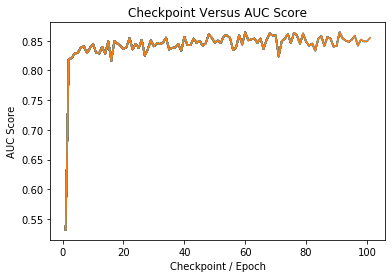

In [15]:
list_checkpoints = sc.create_chkpt_list()
sc.score_chkpts()

#### Save Best Performing Checkpoint / Model

In [16]:
sm = SaveModel()
sm.save_best_model()


Best Checkpoint: cp-0086 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./cp.ckpt/saved_model/assets


#### Load Best Saved Model

In [17]:
model_1 = sm.load_saved_model(summary=True)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               59904     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

#### Create Prediction Using Best Model

In [18]:
y_pred = sm.predict_binarize(model_1, pp.test_sample)
y_pred

The best model and threshold score is being calculated...
auc score: 0.8690410082240482


array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

### Tuned Threshold

In [20]:
y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
y_pred_class = binarize(y_pred, tt.best_threshold)

fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
auc_score = auc(fpr, tpr)

print('auc score:', auc_score)

auc score: 0.8690410082240482


### Base Score

In [21]:
y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
y_pred_class = binarize(y_pred, 0.5)

fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
auc_score = auc(fpr, tpr)

print('auc score:', auc_score)

auc score: 0.8561248362214368
